In [48]:
## Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from quantimpy import morphology as mp
from quantimpy import minkowski as mk
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [49]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'

In [51]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())

diffuser= Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [52]:
if diffuser.diffmodel.has_thetas:
    theta_mean = diffuser.diffmodel.ps.sample_theta(10000).mean(dim=0, keepdim=True).to(device)
    theta_mean

In [53]:
image = diffuser.test_dataloader.dataset[0].unsqueeze(0).unsqueeze(1).to(device)
image.shape

torch.Size([1, 1, 256, 256])

In [54]:
NUM_SAMPLES = 64
NOISE_LEVEL = 0.3

AVG_PS_OF_NOISE = True ## Averages the power spectrum of added_noise on images

In [55]:
all_timesteps = torch.tensor(range(diffuser.diffmodel.sde.N))
all_noise_levels = diffuser.diffmodel.sde.noise_level(all_timesteps).reshape(-1)

In [56]:
closest_timestep = torch.argmin(torch.abs(all_noise_levels - NOISE_LEVEL))

In [57]:
closest_timestep, diffuser.diffmodel.sde.noise_level(closest_timestep).reshape(-1)

(tensor(87, device='cuda:0'), tensor([0.2994], device='cuda:0'))

### No dependence on $\phi$

### Depend on $\phi$

In [58]:
theta = diffuser.diffmodel.ps.sample_theta(1).to(device)
theta[0], theta.shape

(tensor([6.1949e+01, 4.5286e-02], device='cuda:0'), torch.Size([1, 2]))

In [59]:
ps_theta = diffuser.diffmodel.ps(theta) ## You can chose theta close to the mean and see if there is a difference
sqrt_ps_theta = torch.sqrt(ps_theta)

In [60]:
noisy_image, mean_noisy_image, added_noise = diffuser.diffmodel.sde.sampling(image, closest_timestep, sq_ps=sqrt_ps_theta)

Text(0.5, 1.0, 'Noise')

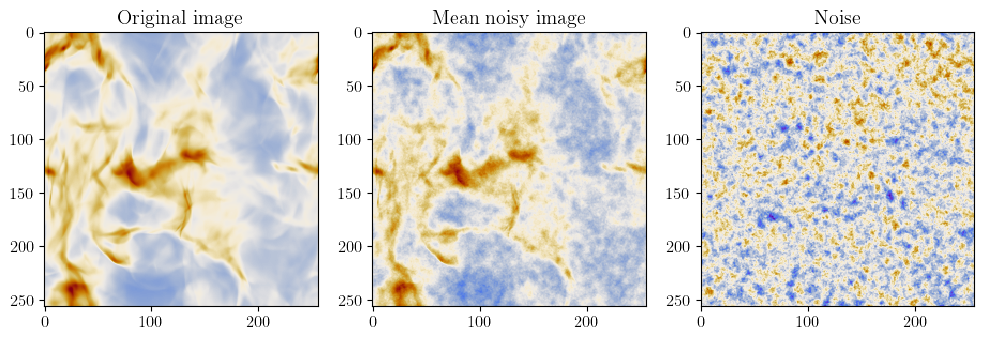

In [61]:
## Plotting the problem
vmin = min(image.min(), noisy_image.min(), added_noise.min())
vmax = max(image.max(), noisy_image.max(), added_noise.max())

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(image[0, 0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[0].set_title('Original image')
ax[1].imshow(noisy_image[0, 0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[1].set_title('Mean noisy image')
ax[2].imshow(added_noise[0, 0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[2].set_title('Noise')


In [62]:
noisy_batch = noisy_image.repeat(NUM_SAMPLES, 1, 1, 1)
theta_batch = theta.repeat(NUM_SAMPLES, 1)

noisy_batch.shape

torch.Size([64, 1, 256, 256])

In [63]:
denoised_batch = diffuser.diffmodel.generate_image(NUM_SAMPLES, sample= noisy_batch, thetas = theta_batch, initial_timestep=closest_timestep.item())

 22%|██▏       | 19/87 [00:00<00:01, 38.70it/s]

100%|██████████| 87/87 [00:02<00:00, 38.17it/s]


In [64]:
estimated_noise = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, closest_timestep.repeat(NUM_SAMPLES)) - denoised_batch
estimated_noise = estimated_noise/NOISE_LEVEL
estimated_noise.shape

torch.Size([64, 1, 256, 256])

Text(0.5, 1.0, 'True image')

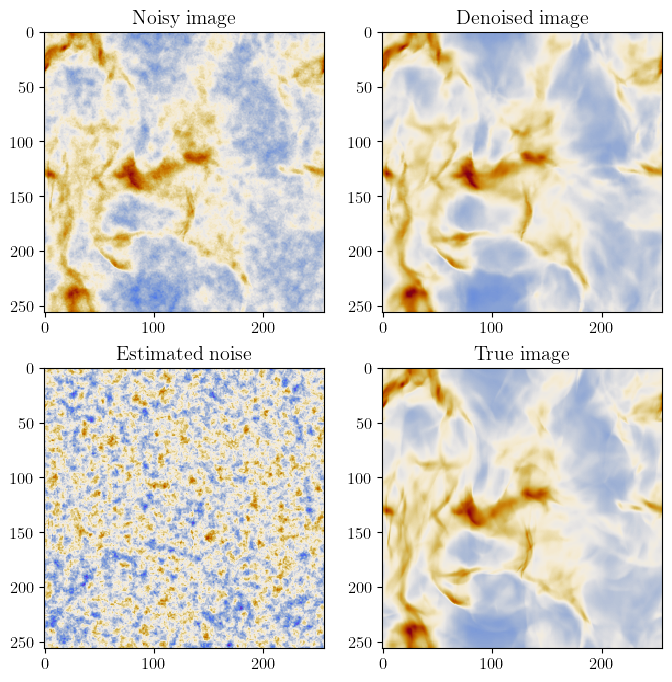

In [65]:
### Plot the results in a square grid: baseline/ noisy image  // denoised image  /  estimated noise

fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].imshow(noisy_batch[0,0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[0,0].set_title('Noisy image')
ax[0,1].imshow(denoised_batch[0,0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[0,1].set_title('Denoised image')
ax[1,0].imshow(estimated_noise[0,0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[1,0].set_title('Estimated noise')
ax[1,1].imshow(image[0,0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[1,1].set_title('True image')


#### Check Twwedie = MMSE estimator

In [81]:
with torch.no_grad():
    residual = diffuser.diffmodel.network(noisy_batch[:1], closest_timestep, theta = theta_batch[:1])
    tweedie_denoised= diffuser.diffmodel.sde.tweedie_reverse(noisy_batch, closest_timestep, residual)


Text(0.5, 1.0, 'Average denoised')

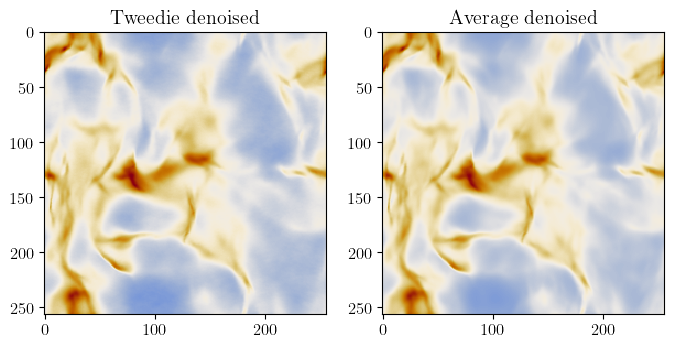

In [83]:
## Compare tweedie denoised and the average of denoised_batch

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(tweedie_denoised[0,0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[0].set_title('Tweedie denoised')
ax[1].imshow(denoised_batch.mean(dim=0)[0].cpu(), cmap='cmb', vmin=vmin, vmax=vmax)
ax[1].set_title('Average denoised')


### Summary Statistics

In [66]:
## Rescale noisy

noisy_batch = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, closest_timestep.repeat(NUM_SAMPLES))

## Rescale the noise

estimated_noise *= NOISE_LEVEL

## Rescale the nosie 

added_noise *= NOISE_LEVEL
if AVG_PS_OF_NOISE:
    added_noise = added_noise.repeat(4*NUM_SAMPLES, 1, 1, 1)

In [67]:
##
## COMPUTTATION OF THE POWER SPECTRUM
##

## Compute power spectrum
bins = torch.linspace(0, np.pi, 100).to(device)

bins_centers = (bins[:-1] + bins[1:])/2
bins_centers = bins_centers.cpu()
mean_list = []
std_list = []
for data in [image, noisy_image, added_noise, denoised_batch, estimated_noise]:
    mean_, std_ , bins = powerSpectrum.set_power_spectrum_iso2d(data.to(device), bins, use_gpu=True)
    mean_list.append(mean_)
    std_list.append(std_)

mean_list = [mean.cpu().numpy() for mean in mean_list]
std_list = [std.cpu().numpy() for std in std_list]

In [68]:
ps_bins = bins_centers.cpu()
ps_mean_list = [mean[:-1] for mean in mean_list]
ps_std_list = [std[:-1] for std in std_list]

In [69]:
l_image = np.split(image, len(image), axis=0)
l_image = [np.ascontiguousarray(l_image[i][0][0].cpu().numpy()) for i in range(len(l_image))]

l_noisy_image = np.split(noisy_image, len(noisy_image), axis=0)
l_noisy_image = [np.ascontiguousarray(l_noisy_image[i][0][0].cpu().numpy()) for i in range(len(l_noisy_image))]

l_added_noise = np.split(added_noise, len(added_noise), axis=0)
l_added_noise = [np.ascontiguousarray(l_added_noise[i][0][0].cpu().numpy()) for i in range(len(l_added_noise))]

l_denoised_batch = np.split(denoised_batch, len(denoised_batch), axis=0)
l_denoised_batch = [np.ascontiguousarray(l_denoised_batch[i][0][0].cpu().numpy()) for i in range(len(l_denoised_batch))]

l_estimated_noise = np.split(estimated_noise, len(estimated_noise), axis=0)
l_estimated_noise = [np.ascontiguousarray(l_estimated_noise[i][0][0].cpu().numpy()) for i in range(len(l_estimated_noise))]

range_min = -3

range_max = 6

gs_vals = np.linspace(range_min, range_max, 200)

sampwise_minkmean  = []
sampwise_minkstd = []
for samp in [l_image, l_noisy_image, l_added_noise, l_denoised_batch, l_estimated_noise]:
    samp_minks = []
    for isa in range(len(samp)):#each image
        image = samp[isa]
        gs_masks = [image>=gs_vals[ig] for ig in range(len(gs_vals))]
        minkowski = []
        for i in range(len(gs_masks)):
            minkowski.append(mk.functionals(gs_masks[i], norm=True))
        minkowski = np.vstack(minkowski) #N_alphax3
        samp_minks.append(minkowski)
    samp_minks = np.stack(samp_minks) #NsampxN_alphax3
    sampwise_minkmean.append(samp_minks.mean(0))
    sampwise_minkstd.append(np.std(samp_minks, axis=0, ddof=1))

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [70]:
mink_x = gs_vals

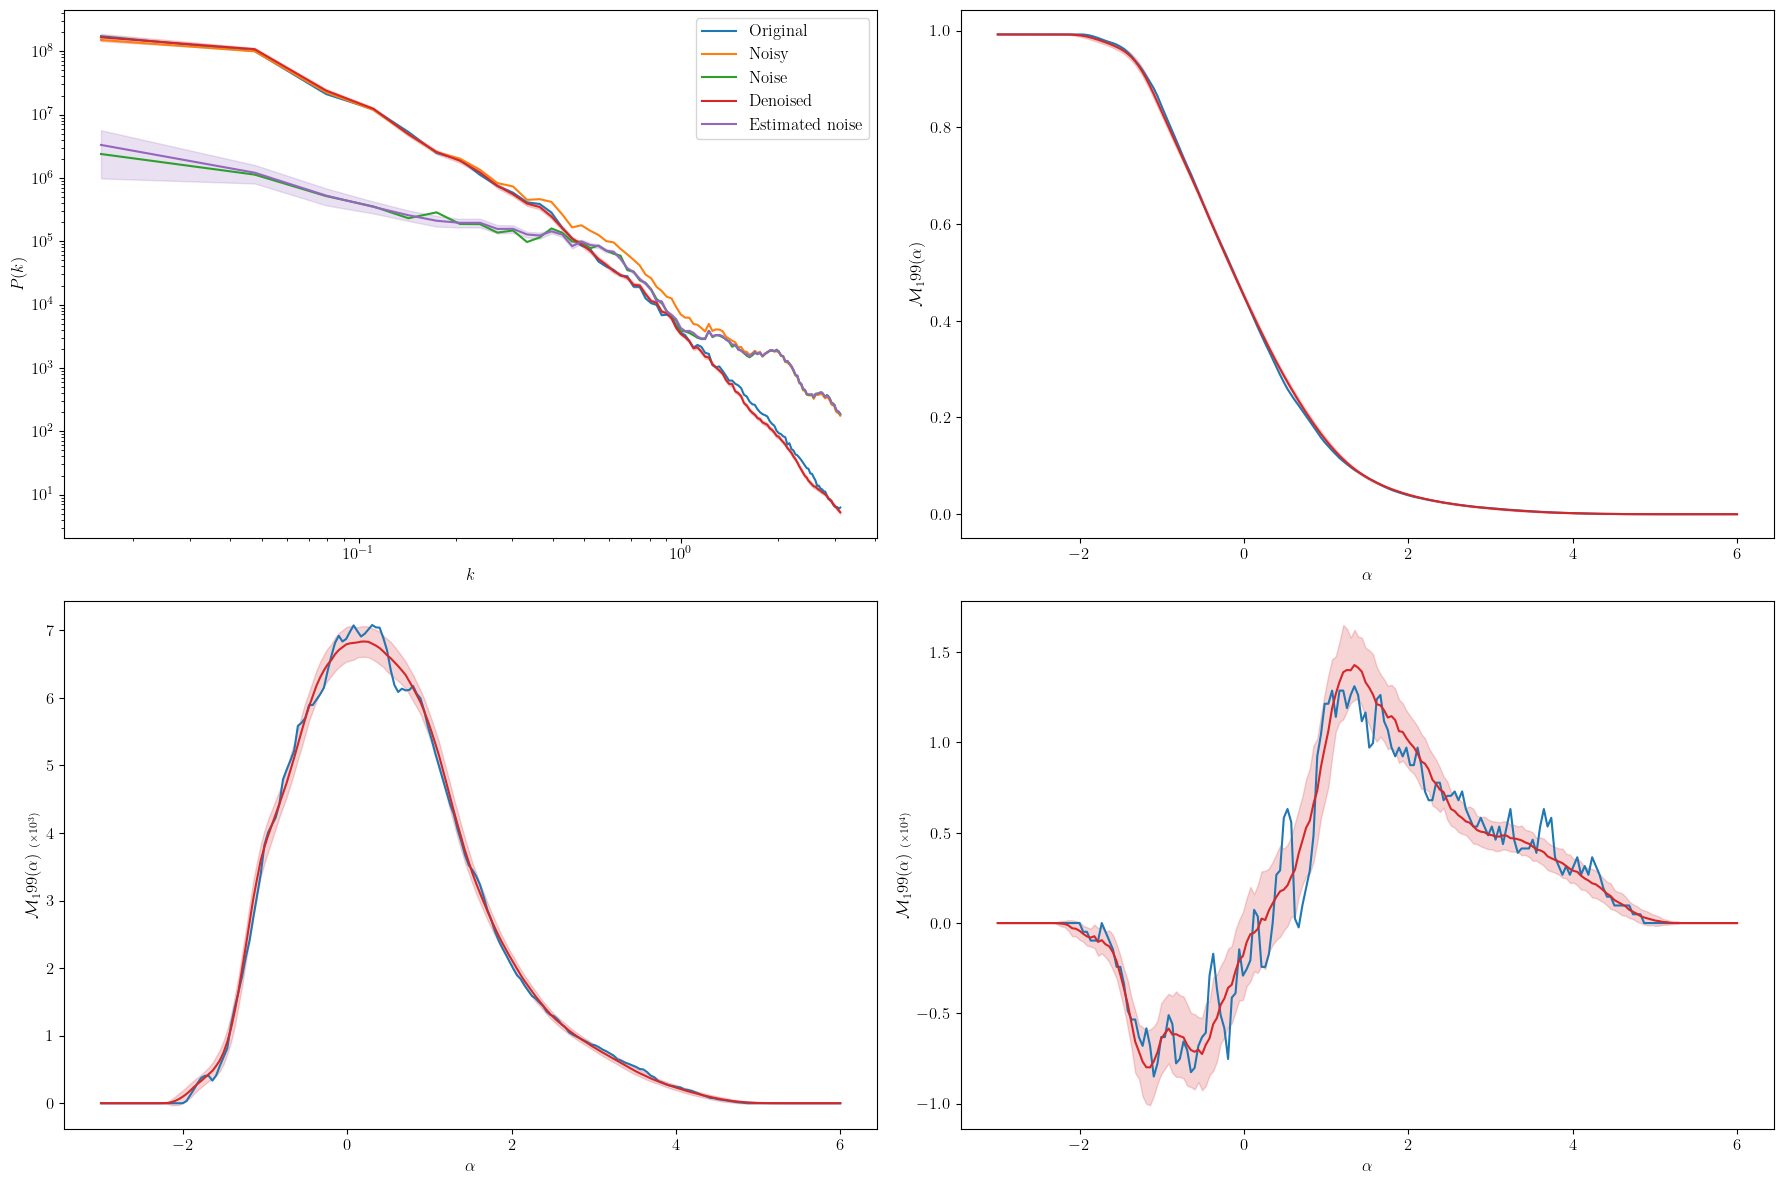

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
labels = ['Original', 'Noisy', 'Noise', 'Denoised', 'Estimated noise']

axs[0,0].plot(ps_bins, ps_mean_list[0], label=labels[0], color='C0')
axs[0,0].plot(ps_bins, ps_mean_list[1], label=labels[1], color='C1')
axs[0,0].plot(ps_bins, ps_mean_list[2], label=labels[2], color='C2')

axs[0,0].plot(ps_bins, ps_mean_list[3], label=labels[3], color='C3')
axs[0,0].fill_between(ps_bins, ps_mean_list[3]-ps_std_list[3], ps_mean_list[3]+ps_std_list[3], alpha=0.2, color='C3')

axs[0,0].plot(ps_bins, ps_mean_list[4], label=labels[4], color='C4')
axs[0,0].fill_between(ps_bins, ps_mean_list[4]-ps_std_list[4], ps_mean_list[4]+ps_std_list[4], alpha=0.2, color='C4')

axs[0,0].set_xlabel(r'$k$')
axs[0,0].set_ylabel(r'$P(k)$')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].legend()

pow_factors = [None, 3, 4] # Renormalization of the Minkowski functionals for better visualization

for j in range(3):
    row = (j + 1)//2
    col = (j + 1)%2

    fac = pow_factors[j]
    label_renorm = ''
    if fac is None:
        fac = 1
    else:
        fac = 10 ** fac
        label_renorm = f'  ${{\\scriptstyle (\\times 10^{{{pow_factors[j]}}})}}$'

    axs[row, col].plot(mink_x, sampwise_minkmean[0][:,j]*fac, color='C0')
    #axs[row, col].plot(mink_x, sampwise_minkmean[1][:,j]*fac, color='C1')
    #axs[row, col].plot(mink_x, sampwise_minkmean[2][:,j]*fac, color='C2')

    axs[row, col].plot(mink_x, sampwise_minkmean[3][:,j]*fac, color='C3')
    axs[row, col].fill_between(mink_x, (sampwise_minkmean[3][:,j]-sampwise_minkstd[3][:,j])*fac, (sampwise_minkmean[3][:,j]+sampwise_minkstd[3][:,j])*fac, alpha=0.2, color='C3')

    #axs[row, col].plot(mink_x, sampwise_minkmean[4][:,j]*fac, color='C4')
    #axs[row, col].fill_between(mink_x, (sampwise_minkmean[4][:,j]-sampwise_minkstd[4][:,j])*fac, (sampwise_minkmean[4][:,j]+sampwise_minkstd[4][:,j])*fac, alpha=0.2, color='C4')

    axs[row, col].set_xlabel(r'$\alpha$')
    axs[row, col].set_ylabel(f'$\\mathcal{{M}}_{i}(\\alpha)$' + label_renorm)

plt.tight_layout()

# if save_fig:
#     if i == 0:
#         fig.savefig('figs/stats_variant_ode.pdf')
#     elif i == 1:
#         fig.savefig('figs/stats_variant_ode_mean.pdf')
#     elif i == 2:
#         fig.savefig('figs/stats_variant_sde.pdf')
#     elif i == 3:
#         fig.savefig('figs/stats_variant_sde_mean.pdf')
plt.show()